In [2]:
# My packages from previous projects
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats import multitest
import statsmodels.api as sm
import pickle
import time
import pyfaidx
from pyfaidx import Fasta
import random
import math
from math import floor
import scipy.stats as stats
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from scipy.interpolate import make_interp_spline, BSpline

#Emily's Packages
import keras
from keras import Input
from keras.preprocessing import sequence
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, BatchNormalization, AveragePooling1D
from keras.layers import concatenate, Reshape, Add
from keras.regularizers import Regularizer, l1, l2
from keras.activations import sigmoid, tanh
from keras.layers import LeakyReLU, ReLU, PReLU
from sklearn.metrics import auc, precision_recall_curve

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras import ops as O

#Packages from BME395
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from keras.utils import set_random_seed
from keras.losses import MeanSquaredError, mean_squared_error, KLDivergence, Huber, BinaryCrossentropy
from keras.initializers import RandomUniform
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, roc_auc_score
import logomaker
from statsmodels.formula.api import ols
import argparse, os, re, sys, itertools, logging, random, time, math
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [13]:
population_dfs = pd.read_pickle('population_splits.pkl')
population_dfs['Train']['Positive']

window_size = 100
print('Sequence_Window: ' + str(window_size))
dfs = ['Train', 'Test', 'Validation']
sets = ['Positive', 'Negative']
model_dfs = dict({'Train': dict({'Positive': [], 'Negative': []}), 'Validation': dict({'Positive': [], 'Negative': []}), 'Test': dict({'Positive': [], 'Negative': []})})
for i in dfs:
    for j in sets:
        ind_df = population_dfs[i][j].copy()
        ind_df['Windowed Encoding'] = ind_df.apply(lambda x: x['One Hot Encoding'][350-int(window_size/2):353+int(window_size/2)], axis=1)
        ind_df['Windowed Seq'] = ind_df.apply(lambda x: x['Sequence'][350-int(window_size/2):353+int(window_size/2)], axis=1)
        model_dfs[i][j] = ind_df


Sequence_Window: 100


In [5]:
negative_test_pop = model_dfs['Test']['Negative']
positive_test_pop = model_dfs['Test']['Positive']
negative_val_pop = model_dfs['Validation']['Negative']
positive_val_pop = model_dfs['Validation']['Positive']
negative_train_pop = model_dfs['Train']['Negative']
positive_train_pop = model_dfs['Train']['Positive']
        
        
X_train_pos = positive_train_pop['Windowed Encoding']
X_test_pos = positive_test_pop['Windowed Encoding']
X_val_pos = positive_val_pop['Windowed Encoding']
y_train_pos = positive_train_pop['Binary Label']
y_test_pos = positive_test_pop['Binary Label']
y_val_pos = positive_val_pop['Binary Label']
train_pos_idx = pd.Series(np.array(positive_train_pop.index))
test_pos_idx = pd.Series(np.array(positive_test_pop.index))
val_pos_idx = pd.Series(np.array(positive_val_pop.index))

train_df = pd.concat([positive_train_pop, negative_train_pop])
test_df = pd.concat([positive_test_pop, negative_test_pop])
val_df = pd.concat([positive_val_pop, negative_val_pop])
positive_train_pop

,Transcript,Gene Name,Chrom,Strand,Location on Transcript,Start Codon,Transcript Index,Coordinate,Label,Genomic idx,Sequence,One Hot Encoding,Input Sequence Center Codon,Binary Label,Windowed Encoding,Windowed Seq
134899,XM_005258465.6,HNRNPUL1,chr19,+,5 UTR,ATG,41.0,41268222.0,2.025298,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",NNNNNNNNNAAACTGCTTTCTGGAGCCGAAGAGAGTCGGAAGAACA...
134898,XM_011526394.4,HNRNPUL1,chr19,+,aTIS,ATG,23.0,41268227.0,2.787866,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",NNNNNNNNNNNNNNNNNNNNNNNNNNNGGGAGTCCAGCGCCTGAGA...
146677,NM_005765.3,ATP6AP2,chrX,+,5 UTR,CTG,26.0,40580995.0,3.780357,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",CTG,1,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",NNNNNNNNNNNNNNNNNNNNNNNNGAGTCCGAGCGCGTCACCTCCT...
146684,NM_005765.3,ATP6AP2,chrX,+,aTIS,ATG,96.0,40581065.0,4.582149,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0,...",CCGCCGGCCCGTTCCGTGTCGCCCCGCAGTGCTGCGGCCGCCGCGG...
146641,XM_017029594.3,POLA1,chrX,+,aTIS,ATG,44.0,24693961.0,6.745933,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",NNNNNNGCCAGTTTTGGGCTGGTTGGCGCGGAATCGGGAGATTCGG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,NM_015871.5,ZNF593,chr1,+,aTIS,ATG,76.0,26169983.0,4.622481,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...",TGCTCCCTGCCCTGCTCCTGGCCCCTTGGCCGGCCGGGCTGTTTCT...
131288,NM_007065.4,CDC37,chr19,-,5 UTR,CTG,11.0,10403530.0,1.973127,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",CTG,1,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGTCTCC...
131293,NM_007065.4,CDC37,chr19,-,aTIS,ATG,63.0,10403478.0,3.475646,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0,...",GCCGCCGTCGCCGCCACCCGAGCCGGAGCGGGCTGGGCCGCCAAGG...
130850,NM_025241.3,UBXN6,chr19,-,aTIS,ATG,97.0,4457696.0,5.115516,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0,...",CCCGTGCCCCCCCGCCCCCGCGGCCCCCCGCCGCCGGGCCAGCCGC...


In [6]:
random.seed(42)
set_random_seed(5)
for i in range(5):
    negative_set_train = negative_train_pop.copy().sample(n=len(train_pos_idx), replace=True)
    negative_set_test = negative_test_pop.copy().sample(n=len(test_pos_idx), replace=True)
    negative_set_val = negative_val_pop.copy().sample(n=len(val_pos_idx), replace=True)

    train_df1 = pd.concat([positive_train_pop, negative_set_train], ignore_index=True)
    train_df1 = train_df1.sample(frac=1)
    val_df = pd.concat([positive_val_pop, negative_set_val], ignore_index=True)
    val_df = val_df.sample(frac=1)
    test_df = pd.concat([positive_test_pop, negative_set_test], ignore_index=True)
    test_df = test_df.sample(frac=1)

    train_df = pd.concat([train_df1, val_df])

    X_train = np.array(train_df['Windowed Encoding'].tolist())
    y_train = np.array(train_df['Binary Label'].tolist())#y is unchanged

    X_test = np.array(test_df['Windowed Encoding'].tolist())
    y_test = np.array(test_df['Binary Label'].tolist())

    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)
    
    #Classification Output Only
    window_size=100
    model_input_seq = Input(shape = [window_size+3, 4])

    x = ReLU()(Conv1D(512, 8, padding = 'valid', strides=1, name='seq_conv')(model_input_seq))
    x = MaxPooling1D(pool_size=3, strides=3, name='bin_pool')(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(units=16, return_sequences=True, name='bin_lstm'))(x)
    x = Flatten(name = 'conv_flatten')(x)

    bin_x = ReLU()(Dense(512, kernel_initializer = 'glorot_uniform', name='bin_dense0')(x))
    bin_x = Dropout(0.5)(bin_x)
    bin_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name='bin_dense1')(bin_x))
    bin_x = Dropout(0.5)(bin_x)
    bin_x = ReLU()(Dense(256, kernel_initializer = 'glorot_uniform', name = 'bin_dense2')(bin_x))
    bin_x = Dropout(0.5)(bin_x)
    bin_x = ReLU()(Dense(64, name = 'bin_dense4')(bin_x))
    bin_x = Dense(1, activation = "sigmoid", name = 'class_predictions')(bin_x)

    model_init = Model(inputs = model_input_seq, outputs = bin_x, name='model')

    model_init.compile(optimizer= Nadam(learning_rate = 0.001), loss = BinaryCrossentropy(reduction="sum_over_batch_size", name="binary_crossentropy"))
    model_init.summary()

    early = EarlyStopping(monitor='val_loss', patience=5)
    checkpoint_filepath = 'checkpoints/checkpoint_model.sample_' + str(i)+'.keras'

    model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_loss', save_best_only=True, save_freq="epoch")

    csv_logger = CSVLogger(filename = 'model.history.sample_'+str(i)+'.csv', append = True)

    model_init.fit(X_train, y_train, batch_size=32, epochs=15, validation_split=0.1, callbacks=[model_checkpoint_callback, csv_logger])

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 103, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_conv (Conv1D)               │ (None, 96, 512)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 96, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_pool (MaxPooling1D)         │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 32)         │        67,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_flatten (Flatten)          │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense0 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense1 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense2 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense4 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_predictions (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,041 (3.14 MB)

 Trainable params: 823,041 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.6946 - val_loss: 0.5854
Epoch 2/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5174 - val_loss: 0.4141
Epoch 3/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3779 - val_loss: 0.3844
Epoch 4/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3397 - val_loss: 0.3898
Epoch 5/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3174 - val_loss: 0.3776
Epoch 6/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2958 - val_loss: 0.3903
Epoch 7/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2674 - val_loss: 0.3992
Epoch 8/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2423 - val_loss: 0.4213
Epoch 9/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2113 - val_loss: 0.4132
Epoch 10/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1846 - val_loss: 0.4572
Epoch 11/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1646 - val_loss: 0.4917
Epoch 12/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 103, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_conv (Conv1D)               │ (None, 96, 512)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 96, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_pool (MaxPooling1D)         │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32, 32)         │        67,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_flatten (Flatten)          │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense0 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense1 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense2 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense4 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_predictions (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,041 (3.14 MB)

 Trainable params: 823,041 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.6939 - val_loss: 0.6302
Epoch 2/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5434 - val_loss: 0.4105
Epoch 3/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3988 - val_loss: 0.3928
Epoch 4/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3603 - val_loss: 0.3798
Epoch 5/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3368 - val_loss: 0.3711
Epoch 6/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3050 - val_loss: 0.3890
Epoch 7/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2992 - val_loss: 0.4147
Epoch 8/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2625 - val_loss: 0.4373
Epoch 9/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2303 - val_loss: 0.5083
Epoch 10/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1995 - val_loss: 0.5405
Epoch 11/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1696 - val_loss: 0.5429
Epoch 12/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 103, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_conv (Conv1D)               │ (None, 96, 512)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 96, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_pool (MaxPooling1D)         │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32, 32)         │        67,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_flatten (Flatten)          │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense0 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense1 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense2 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense4 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_predictions (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,041 (3.14 MB)

 Trainable params: 823,041 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.6914 - val_loss: 0.5529
Epoch 2/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5012 - val_loss: 0.3882
Epoch 3/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3946 - val_loss: 0.3844
Epoch 4/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3530 - val_loss: 0.3930
Epoch 5/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3310 - val_loss: 0.4117
Epoch 6/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3075 - val_loss: 0.4077
Epoch 7/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2766 - val_loss: 0.5016
Epoch 8/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2489 - val_loss: 0.4583
Epoch 9/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2314 - val_loss: 0.4892
Epoch 10/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1979 - val_loss: 0.5159
Epoch 11/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1817 - val_loss: 0.5790
Epoch 12/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 103, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_conv (Conv1D)               │ (None, 96, 512)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 96, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_pool (MaxPooling1D)         │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32, 32)         │        67,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_flatten (Flatten)          │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense0 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense1 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense2 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense4 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_predictions (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,041 (3.14 MB)

 Trainable params: 823,041 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.6947 - val_loss: 0.6002
Epoch 2/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5516 - val_loss: 0.3766
Epoch 3/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3993 - val_loss: 0.3622
Epoch 4/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3625 - val_loss: 0.3655
Epoch 5/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3351 - val_loss: 0.3659
Epoch 6/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3130 - val_loss: 0.3865
Epoch 7/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2844 - val_loss: 0.3882
Epoch 8/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2451 - val_loss: 0.3974
Epoch 9/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2258 - val_loss: 0.4406
Epoch 10/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2003 - val_loss: 0.4594
Epoch 11/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1635 - val_loss: 0.4982
Epoch 12/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 103, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_conv (Conv1D)               │ (None, 96, 512)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 96, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_pool (MaxPooling1D)         │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32, 32)         │        67,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_flatten (Flatten)          │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense0 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense1 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense2 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense4 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_predictions (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,041 (3.14 MB)

 Trainable params: 823,041 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.6962 - val_loss: 0.6078
Epoch 2/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5342 - val_loss: 0.4080
Epoch 3/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4065 - val_loss: 0.3806
Epoch 4/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3683 - val_loss: 0.3718
Epoch 5/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3426 - val_loss: 0.3798
Epoch 6/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3168 - val_loss: 0.3915
Epoch 7/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2978 - val_loss: 0.3872
Epoch 8/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2742 - val_loss: 0.3838
Epoch 9/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2479 - val_loss: 0.4524
Epoch 10/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2215 - val_loss: 0.5013
Epoch 11/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1830 - val_loss: 0.5812
Epoch 12/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:
positive_train_pop[positive_train_pop['Label'] >= 3.5]

,Transcript,Gene Name,Chrom,Strand,Location on Transcript,Start Codon,Transcript Index,Coordinate,Label,Genomic idx,Sequence,One Hot Encoding,Input Sequence Center Codon,Binary Label,Windowed Encoding,Windowed Seq
146677,NM_005765.3,ATP6AP2,chrX,+,5 UTR,CTG,26.0,40580995.0,3.780357,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",CTG,1,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",NNNNNNNNNNNNNNNNNNNNNNNNGAGTCCGAGCGCGTCACCTCCT...
146684,NM_005765.3,ATP6AP2,chrX,+,aTIS,ATG,96.0,40581065.0,4.582149,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0,...",CCGCCGGCCCGTTCCGTGTCGCCCCGCAGTGCTGCGGCCGCCGCGG...
146641,XM_017029594.3,POLA1,chrX,+,aTIS,ATG,44.0,24693961.0,6.745933,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",NNNNNNGCCAGTTTTGGGCTGGTTGGCGCGGAATCGGGAGATTCGG...
101563,NM_001400929.1,PARPBP,chr12,+,aTIS,ATG,107.0,102123888.0,4.696980,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0,...",TCCTTCCGCACACTGAAGAGTACGTCTTCGGGTCTACCCCTAATCA...
46991,NM_004640.7,DDX39B,chr6,-,aTIS,ATG,186.0,31540531.0,4.204956,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1,...",GCGAGAACCCATCCAGATCCCCCTTCCCTTCTTCCCCTGCCGGCCC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128731,NM_033546.4,MYL12B,chr18,+,5 UTR,GTG,61.0,3262193.0,4.287250,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",GTG,1,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,...",GTCGGCGCCGCCACTGTCCGGCCACAGCCTAACGCTCTTCGCTGTC...
128783,NM_001144945.1,MYL12B,chr18,+,aTIS,ATG,81.0,3272898.0,5.196209,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0,...",GCCTAAGGTGAAGCCTCCAAGGAAGCCATTAGCATAATTAAACAAC...
2501,NM_015871.5,ZNF593,chr1,+,aTIS,ATG,76.0,26169983.0,4.622481,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...",TGCTCCCTGCCCTGCTCCTGGCCCCTTGGCCGGCCGGGCTGTTTCT...
130850,NM_025241.3,UBXN6,chr19,-,aTIS,ATG,97.0,4457696.0,5.115516,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",ATG,1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0,...",CCCGTGCCCCCCCGCCCCCGCGGCCCCCCGCCGCCGGGCCAGCCGC...


In [8]:
random.seed(42)
set_random_seed(5)
negative_set_train = negative_train_pop.copy().sample(n=len(train_pos_idx), replace=True)
negative_set_test = negative_test_pop.copy().sample(n=len(test_pos_idx), replace=True)
negative_set_val = negative_val_pop.copy().sample(n=len(val_pos_idx), replace=True)

train_df1 = pd.concat([positive_train_pop, negative_set_train], ignore_index=True)
train_df1 = train_df1.sample(frac=1)
val_df = pd.concat([positive_val_pop, negative_set_val], ignore_index=True)
val_df = val_df.sample(frac=1)
test_df = pd.concat([positive_test_pop, negative_set_test], ignore_index=True)
test_df = test_df.sample(frac=1)

train_df = pd.concat([train_df1, val_df])

X_train = np.array(train_df['Windowed Encoding'].tolist())
y_train = np.array(train_df['Binary Label'].tolist())#y is unchanged

X_test = np.array(test_df['Windowed Encoding'].tolist())
y_test = np.array(test_df['Binary Label'].tolist())

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [9]:
for i in range(5):
    mod = load_model('checkpoints/checkpoint_model.sample_' + str(i)+'.keras')
    pred = mod.predict(X_test)
    test_df['pred '+str(i)] = pred

test_df['pred'] = test_df.apply(lambda x: np.mean([x['pred 0'], x['pred 1'], x['pred 2'], x['pred 3'], x['pred 4']]), axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


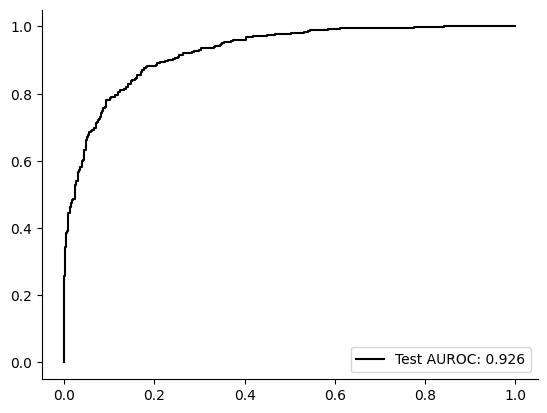

In [ ]:
fpr3, tpr3, roc_thresholds1 = roc_curve(test_df['Binary Label'].tolist(), test_df['pred'].tolist())
fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
ax.plot(fpr3, tpr3, label = 'Test AUROC: '+str(round(auc(fpr3, tpr3), 3)), color='black')
plt.legend(loc='lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()